# Projeto 3 - Google Play Store Apps

Ciências dos Dados

**Arthur Ventrilho**

**Gabriel Zanetti**

**Roger Pina**

In [139]:
%matplotlib inline
import pandas as pd
import numpy as np
import math
from scipy import stats
import mpmath
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import norm, probplot, t

In [162]:
# Função utilitária para fazer a regressão com constante adicionada
def regress_cp(X,Y):
    X_cp = sm.add_constant(X)
    model = sm.OLS(Y,X_cp)
    results = model.fit()
    return results

def regress(X,Y):
    X_cp = sm.add_constant(X)
    model = sm.OLS(Y,X)
    results = model.fit()
    return results

In [163]:
#Função que transforma colunas categóricas em colunas quantitativas
def dummify(data, column_name):
    """
        Converte a coluna column_name em dummies / one-hot e as adiciona ao dataframe
        retorna uma copia do  df original *sem* a coluna que foi dummified
    """
    df = data.copy()
    # Nota: se você for um econometrista, pode se interessar por usar a opção dropFirst = True na get_dummies
    df2 = pd.concat([df.drop(column_name, axis=1), pd.get_dummies(data[column_name], prefix=column_name + "_")], axis=1)
    return df2

In [164]:
data = pd.read_csv('googleplaystore.csv')
data = data.dropna(axis=0)

## Etapa 1: Arrumando os dados

In [165]:
del data['Genres']
del data['Last Updated']
del data['Current Ver']
del data['Android Ver']

In [166]:
#Tranformando Installs em quant
deletar = ['+', ',']
Installs_novo = []
for frase in data['Installs']:
    for c in deletar:
        frase = frase.replace(c , "")
    Installs_novo.append(frase)
Installs_novo
data['Installs'] = pd.Series((Installs_novo), index = data.index)

In [167]:
#Deixando Price em quant
deletar = ['$']
Price_novo = []
for frase in data['Price']:
    for c in deletar:
        frase = frase.replace(c , "")
    Price_novo.append(frase)
data['Price'] = pd.Series((Price_novo), index = data.index)

In [168]:
data = data.drop(data[data.Size == "Varies with device"].index)
def retira_letras(coluna):
    listaA = []
    if coluna == 'Size':
        for linha in data[coluna]:
            if linha[-1] == 'k':
                listaA.append(int(float(linha[:-1]) * 1000))
            elif linha[-1] == 'M':
                listaA.append(int(float(linha[:-1]) * 1000000))
    data[coluna] = pd.Series((listaA), index = data.index)
retira_letras('Size')

In [169]:
data.head(5)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19000000,10000,Free,0,Everyone
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14000000,500000,Free,0,Everyone
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8700000,5000000,Free,0,Everyone
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25000000,50000000,Free,0,Teen
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2800000,100000,Free,0,Everyone


In [170]:
def transforma_em_numero():
    colunas_int = ['Reviews', 'Size', 'Installs']
    colunas_ft = ['Rating', 'Price']
    
    for coluna in colunas_ft:
        listaft = []
        for linha in data[coluna]:
            listaft.append(float(linha))
        data[coluna] = pd.Series((listaft), index = data.index)
    
    for coluna in colunas_int:
        lista = []
        for linha in data[coluna]:
            lista.append(int(linha))
        data[coluna] = pd.Series((lista), index = data.index)
transforma_em_numero()

In [171]:
#Declarando Categórico
data.Category = data.Category.astype('category')
data.Type = data.Type.astype('category')
data['Content Rating'] = data['Content Rating'].astype('category')

In [172]:
#Declarando Quantitativas
quantitativas = ['Rating', 'Reviews', 'Size', 'Installs', 'Price']

## Etapa 2: Rating como saída

#### 2.1: Regressão Linear somente com as colunas quantitativas 

In [173]:
#Separando a coluna que será a saída
quant = quantitativas.copy()
quant.remove('Rating')

In [174]:
#Fazendo a regressão
results = regress_cp(data.loc[:, quant], data.Rating)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     21.74
Date:                Tue, 13 Nov 2018   Prob (F-statistic):           7.33e-18
Time:                        08:27:06   Log-Likelihood:                -6221.9
No. Observations:                7723   AIC:                         1.245e+04
Df Residuals:                    7718   BIC:                         1.249e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.1328      0.009    476.509      0.000       4.116       4.150
Reviews     1.796e-08   4.31e-09      4.164      0.000     9.5e-09    2.64e-08
Size        1.577e-09   2.71e-10      5.819      0.000    1.05e-09    2.11e-09
Installs    3.215e-11   1.58e-10      0.204      0.838   -2.77e-10    3.41e-10
Price         -0.0006      0.000     -1.667      0.096      -0.001       0.000
==============================================================================
Omnibus:                     2752.071   Durbin-Watson:                   1.807
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11889.252
Skew:                          -1.708   Prob(JB):                         0.00
Kurtosis:                       8.028   Cond. No.                     7.28e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.28e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Analisando os dados podemos concluir que os resídeuos da nossa regressão linear não seguem uma distribuição normal, isso foi visto através da Prob(Omnibus) e Prob(JB) que foram altas, com isso não podemos confiar no p-value. 

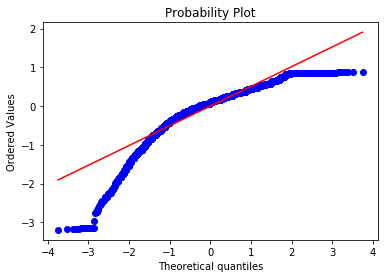

In [175]:
#Justificativa do que foi afirmado acima
probplot(results.resid, dist="norm", plot=plt);

#### 2.2: Tirando a constante da regressão linear

In [176]:
#Fazendo a regressão
results = regress(data.loc[:, quant], data.Rating)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                     1903.
Date:                Tue, 13 Nov 2018   Prob (F-statistic):               0.00
Time:                        08:27:28   Log-Likelihood:                -19409.
No. Observations:                7723   AIC:                         3.883e+04
Df Residuals:                    7719   BIC:                         3.885e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Reviews     -1.39e-07   2.37e-08     -5.863      0.000   -1.86e-07   -9.26e-08
Size        9.065e-08   1.08e-09     83.803      0.000    8.85e-08    9.28e-08
Installs    3.943e-09   8.68e-10      4.540      0.000    2.24e-09    5.64e-09
Price          0.0103      0.002      5.276      0.000       0.006       0.014
==============================================================================
Omnibus:                     1439.144   Durbin-Watson:                   0.783
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2401.111
Skew:                          -1.258   Prob(JB):                         0.00
Kurtosis:                       4.063   Cond. No.                     2.97e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.97e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### 2.3: Transformando as colunas categóricas em quantitativas

In [154]:
#Covertendo Category
cat = dummify(data, "Category")

In [155]:
quant.extend(['Category__ART_AND_DESIGN', 'Category__AUTO_AND_VEHICLES','Category__BEAUTY', 'Category__BOOKS_AND_REFERENCE',
       'Category__BUSINESS', 'Category__COMICS', 'Category__COMMUNICATION','Category__DATING', 'Category__EDUCATION', 'Category__ENTERTAINMENT',
       'Category__EVENTS', 'Category__FAMILY', 'Category__FINANCE','Category__FOOD_AND_DRINK', 'Category__GAME',
       'Category__HEALTH_AND_FITNESS', 'Category__HOUSE_AND_HOME','Category__LIBRARIES_AND_DEMO', 'Category__LIFESTYLE',
       'Category__MAPS_AND_NAVIGATION', 'Category__MEDICAL','Category__NEWS_AND_MAGAZINES', 'Category__PARENTING',
       'Category__PERSONALIZATION', 'Category__PHOTOGRAPHY','Category__PRODUCTIVITY', 'Category__SHOPPING', 'Category__SOCIAL',
       'Category__SPORTS', 'Category__TOOLS', 'Category__TRAVEL_AND_LOCAL','Category__VIDEO_PLAYERS', 'Category__WEATHER'])

In [156]:
#Covertendo Type
tp = dummify(cat, "Type")

In [157]:
quant.extend(['Type__Free','Type__Paid'])

In [158]:
#Covertendo Content Rating
df = dummify(tp, "Content Rating")

In [159]:
quant.extend(['Content Rating__Adults only 18+', 'Content Rating__Everyone','Content Rating__Everyone 10+', 'Content Rating__Mature 17+',
       'Content Rating__Teen', 'Content Rating__Unrated'])

In [160]:
#Refazendo a regressao após adicionar todas as categóricas que foram transformadas em quant
results = regress(df.loc[:, quant], data.Rating)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     7.711
Date:                Tue, 13 Nov 2018   Prob (F-statistic):           4.38e-44
Time:                        08:23:00   Log-Likelihood:                -6105.7
No. Observations:                7723   AIC:                         1.230e+04
Df Residuals:                    7680   BIC:                         1.260e+04
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               2.5278      0.065     38.742      0.000       2.400       2.656
Reviews                          1.753e-08   4.33e-09      4.051      0.000    9.05e-09     2.6e-08
Size                             1.077e-09   3.01e-10      3.582      0.000    4.87e-10    1.67e-09
Installs                         5.861e-11   1.57e-10      0.374      0.709   -2.49e-10    3.66e-10
Price                              -0.0009      0.000     -2.367      0.018      -0.002      -0.000
Category__ART_AND_DESIGN            0.2794      0.069      4.062      0.000       0.145       0.414
Category__AUTO_AND_VEHICLES         0.0424      0.066      0.641      0.522      -0.087       0.172
Category__BEAUTY                    0.1933      0.086      2.252      0.024       0.025       0.362
Category__BOOKS_AND_REFERENCE       0.2174      0.044      4.912      0.000       0.131       0.304
Category__BUSINESS                  0.0180      0.034      0.522      0.602      -0.050       0.086
Category__COMICS                    0.0228      0.075      0.303      0.762      -0.125       0.170
Category__COMMUNICATION            -0.0122      0.037     -0.329      0.742      -0.085       0.060
Category__DATING                   -0.1292      0.051     -2.513      0.012      -0.230      -0.028
Category__EDUCATION                 0.2785      0.050      5.527      0.000       0.180       0.377
Category__ENTERTAINMENT             0.0283      0.056      0.502      0.615      -0.082       0.139
Category__EVENTS                    0.3795      0.085      4.481      0.000       0.213       0.546
Category__FAMILY                    0.0630      0.016      3.856      0.000       0.031       0.095
Category__FINANCE                   0.0128      0.033      0.384      0.701      -0.053       0.078
Category__FOOD_AND_DRINK           -0.0129      0.057     -0.224      0.823      -0.125       0.100
Category__GAME                      0.1011      0.021      4.742      0.000       0.059       0.143
Category__HEALTH_AND_FITNESS        0.1115      0.036      3.095      0.002       0.041       0.182
Category__HOUSE_AND_HOME            0.0611      0.070      0.873      0.383      -0.076       0.198
Category__LIBRARIES_AND_DEMO        0.1096      0.067      1.631      0.103      -0.022       0.241
Category__LIFESTYLE                -0.0054      0.032     -0.165      0.869      -0.069       0.058
Category__MAPS_AND_NAVIGATION      -0.0913      0.054     -1.688      0.091      -0.197       0.015
Category__MEDICAL                   0.0614      0.031      2.003      0.045       0.001       0.122
Category__NEWS_AND_MAGAZINES        0.0412      0.042      0.992      0.321      -0.040       0.123
Category__PARENTING                 0.2407      0.079      3.054      0.002       0

In [161]:
quant.remove('Installs')
quant.remove('Category__DATING')
quant.remove('Category__MAPS_AND_NAVIGATION')
quant.remove('Category__TOOLS')


results = regress(df.loc[:, quant], data.Rating)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     8.291
Date:                Tue, 13 Nov 2018   Prob (F-statistic):           2.40e-45
Time:                        08:23:01   Log-Likelihood:                -6106.0
No. Observations:                7723   AIC:                         1.229e+04
Df Residuals:                    7683   BIC:                         1.257e+04
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               2.4690      0.067     36.981      0.000       2.338       2.600
Reviews                           1.85e-08   3.45e-09      5.356      0.000    1.17e-08    2.53e-08
Size                             1.077e-09      3e-10      3.587      0.000    4.88e-10    1.67e-09
Price                              -0.0009      0.000     -2.371      0.018      -0.002      -0.000
Category__ART_AND_DESIGN            0.3753      0.073      5.164      0.000       0.233       0.518
Category__AUTO_AND_VEHICLES         0.1381      0.070      1.972      0.049       0.001       0.275
Category__BEAUTY                    0.2895      0.090      3.221      0.001       0.113       0.466
Category__BOOKS_AND_REFERENCE       0.3134      0.048      6.490      0.000       0.219       0.408
Category__BUSINESS                  0.1138      0.039      2.926      0.003       0.038       0.190
Category__COMICS                    0.1208      0.079      1.526      0.127      -0.034       0.276
Category__COMMUNICATION             0.0848      0.041      2.058      0.040       0.004       0.166
Category__EDUCATION                 0.3747      0.054      6.891      0.000       0.268       0.481
Category__ENTERTAINMENT             0.1263      0.060      2.090      0.037       0.008       0.245
Category__EVENTS                    0.4754      0.089      5.354      0.000       0.301       0.649
Category__FAMILY                    0.1594      0.024      6.756      0.000       0.113       0.206
Category__FINANCE                   0.1085      0.038      2.859      0.004       0.034       0.183
Category__FOOD_AND_DRINK            0.0830      0.061      1.351      0.177      -0.037       0.203
Category__GAME                      0.1988      0.028      7.169      0.000       0.144       0.253
Category__HEALTH_AND_FITNESS        0.2079      0.040      5.136      0.000       0.129       0.287
Category__HOUSE_AND_HOME            0.1569      0.074      2.122      0.034       0.012       0.302
Category__LIBRARIES_AND_DEMO        0.2053      0.071      2.891      0.004       0.066       0.344
Category__LIFESTYLE                 0.0907      0.037      2.450      0.014       0.018       0.163
Category__MEDICAL                   0.1574      0.035      4.454      0.000       0.088       0.227
Category__NEWS_AND_MAGAZINES        0.1394      0.046      3.057      0.002       0.050       0.229
Category__PARENTING                 0.3367      0.083      4.067      0.000       0.174       0.499
Category__PERSONALIZATION           0.3010      0.037      8.097      0.000       0.228       0.374
Category__PHOTOGRAPHY               0.1304      0.039      3.306      0.001       0.053       0.208
Category__PRODUCTIVITY              0.1353      0.040      3.423      0.001       0